<h1><center>Payment Data Analysis</center></h1>
<h3><center>Jeffrey Hsu</center></h3>

In this analysis, we try to answer the following three questions:
* 1. Cohort analysis
* 2. What are the features found within the data that can suggest a tangible solution to increase conversion rate on vouchers?
* 3. Does longer journey results in (e.g. or at least correlated with) higher or lower conversion rate on vouchers?

In [359]:
# Loading python packages
import sys
import warnings
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

### Loading Data

In [321]:
log = pd.read_csv("catalog.csv", sep="|")
transfers = pd.read_csv("transfer_job.csv", sep="|")
payments = pd.read_csv("payment_job.csv", sep="|")

### Inspect data structure

First, we want to check each table's structures and their column relations. Also, we would like to do some sanity check to see if the the uniqueness of table keys and the 1:N relationship between payments and transfers are as described.

In [230]:
payments.head(5)

,payment_job_id,payment_issuer_id,amount,gender,status,created_at,closed_at
0,3N2/gEX,ku67iuf,65.26,Male,Closed,2017-03-28 02:06:34.254341+00,2017-03-28 11:08:15.763343+00
1,t1hcFJ4,zxqi2ey,10.25,Male,Closed,2017-03-28 02:06:09.88215+00,2017-03-28 12:06:04.563339+00
2,bozVMtI,ku67iuf,96.18,Male,Closed,2017-03-28 02:06:25.162234+00,2017-03-28 12:00:34.403814+00
3,17OYtBy,ku67iuf,122.21,Male,Closed,2017-03-28 02:06:16.679556+00,2017-03-28 12:38:46.746275+00
4,ZymI3ly,ku67iuf,51.59,Female,Closed,2017-03-28 02:06:17.902805+00,2017-03-28 12:53:09.966339+00


In [208]:
transfers[25:35]

,transfer_job_id,payment_job_id,transfer_method_id,nominal_value,payout_method_id,status,created_at,updated_at,upside_amount
25,3R8poR6,RzcCaF4,sopntbn,89.81,22yufl6,CLOSED,2017-03-23 21:14:32.194885+00,2017-03-23 21:14:57.243903+00,0.0
26,jUcZrWq,SAiJTfA,sopntbn,200.18,22yufl6,CLOSED,2017-03-24 08:00:07.10182+00,2017-03-24 08:00:28.197823+00,0.0
27,ewI/EXl,5CvsQl0,sopntbn,2940.00,22yufl6,CLOSED,2017-03-24 08:00:07.250803+00,2017-03-24 08:00:27.8514+00,0.0
28,zLqZVeO,nWjVANx,sopntbn,1365.74,22yufl6,CLOSED,2017-03-24 08:00:07.217147+00,2017-03-24 08:00:28.072865+00,0.0
29,JtM2JiQ,iUN4oF/,sopntbn,255.85,22yufl6,CLOSED,2017-03-24 08:00:07.061651+00,2017-03-24 08:00:27.678761+00,0.0
30,SBl+qQi,8eIOzUe,sopntbn,167.00,22yufl6,CLOSED,2017-04-02 20:50:42.284774+00,2017-04-02 20:50:57.230321+00,0.0
31,93UXy3n,Ro4wumd,sopntbn,13.12,22yufl6,CLOSED,2017-03-24 09:06:27.970877+00,2017-03-24 09:06:57.212641+00,0.0
32,RzAd/tm,zj8ht+m,sopntbn,24.29,22yufl6,CLOSED,2017-03-24 10:36:42.639543+00,2017-03-24 10:36:57.27015+00,0.0
33,Lhcul9t,AOsN8yR,6zqi3zy,20.00,NaN,CLOSED,2017-04-24 15:54:34.704354+00,2017-04-24 15:55:27.270089+00,0.0
34,rvZn9cA,Nb9dHuX,6zqi3zy,40.00,NaN,CLOSED,2017-04-24 15:55:08.644198+00,2017-04-24 15:55:57.187104+00,0.0


By just eyeballing several selected records, we can notice:
* records where payout_method_id is not null correspond to payouts
* records where payout_method_id is null correspond to vouchers

In [322]:
upside_transfers = transfers[transfers.upside_amount != 0]
print(upside_transfers[~upside_transfers.payout_method_id.isnull()].shape)
upside_transfers.head(5)

(0, 9)


,transfer_job_id,payment_job_id,transfer_method_id,nominal_value,payout_method_id,status,created_at,updated_at,upside_amount
16,wX2drt5,YMZWxxX,rfqzuz2,20.00,NaN,CLOSED,2017-04-02 16:46:18.3472+00,2017-04-02 16:46:57.329727+00,2.0000
19,pd4wLll,ndYquZx,rfqzuz2,20.00,NaN,CLOSED,2017-04-02 16:48:30.548459+00,2017-04-02 16:49:27.337693+00,2.0000
42,65be3zD,hMPzyxJ,s66vazx,40.00,NaN,CLOSED,2017-04-03 13:28:04.239687+00,2017-04-03 13:28:57.365303+00,10.0000
54,yCFAEm4,Dcs6EvG,ybaa3gk,323.57,NaN,CLOSED,2017-03-25 15:12:12.204516+00,2017-03-25 15:12:57.30173+00,12.9428
57,dPqIbv/,6CgtNF9,ybaa3gk,235.04,NaN,CLOSED,2017-03-03 09:03:00.453757+00,2017-03-03 09:03:57.518374+00,9.4016


We see that all the transfers that comes with upside amount are done with voucher. There're 2 possibilities that results in this:
* The upside amount is only offered when customer select voucher for reimbursement. That said, only payments that has at least partial voucher refund gives upside amount.
* The upside amount is attracting customers to use voucher due to their positive experience with the shop. 

We can look further into these 2 scenarios later. 

In [210]:
log[25:35]

,payment_job_id,url_view,transfer_method_id,created_at
25,4vNdI3J,campaigns,NaN,2017-02-15 10:15:04.99676+00
26,4vNdI3J,campaigns,NaN,2017-02-15 10:15:05.741158+00
27,DAxRnhZ,payout-methods,NaN,2017-02-15 10:23:24.920076+00
28,DAxRnhZ,campaigns,NaN,2017-02-15 10:23:24.927665+00
29,DAxRnhZ,campaigns,NaN,2017-02-15 10:23:25.002216+00
30,DAxRnhZ,transfer-method,zkloavz,2017-02-15 10:23:38.838475+00
31,4vNdI3J,transfer-method,zkloavz,2017-02-15 10:26:05.134305+00
32,4vNdI3J,payout-methods,NaN,2017-02-15 10:26:56.577137+00
33,4vNdI3J,campaigns,NaN,2017-02-15 10:27:00.474495+00
34,4vNdI3J,campaigns,NaN,2017-02-15 10:27:36.97355+00


In [323]:
print('Number of records in the payment job table is', payments.shape[0])
print('Number of records in the transfer job table is', transfers.shape[0])
print('Number of records in the log table is', log.shape[0])

Number of records in the payment job table is 1350
Number of records in the transfer job table is 1316
Number of records in the log table is 6072


### Data sanity check

In [236]:
# Check that every record in transfer jobs table has a corresponding payment record initiated
transfers[~transfers.payment_job_id.isin(payments.payment_job_id)].shape[0]

0

In [235]:
# Check that every and only Closed payment jobs are converted to trasfer jobs
payments[ ( ~payments.payment_job_id.isin(transfers.payment_job_id) ) & 
          ( ~payments.status.isin(["Start", "New", "Open", "Cancelled"]) )].shape[0]

0

### What are the characteristics of payments that resulted in vouchers?

In [324]:
# Add isMale booleon column
payments["isMale"] = (payments.gender == "Male")*1

# in total 84 transfers were done via vouchers
vouchers = transfers[transfers.payout_method_id.isnull()]
payouts = transfers[~transfers.payout_method_id.isnull()]

In [325]:
payments_with_voucher = payments[payments.payment_job_id.isin(vouchers.payment_job_id)]
payments_with_fallback = payments[(payments.payment_job_id.isin(payouts.payment_job_id)) &
                                  (payments.status =="Fallback")]
payments_with_payout = payments[(payments.payment_job_id.isin(payouts.payment_job_id)) &
                               (payments.status =="Closed")]

print("Number of payment jobs with at least 1 voucher:", payments_with_voucher.shape[0])
print("Number of payment jobs ended with fallback auto-payout:", payments_with_fallback.shape[0])
print("Number of payment jobs with user-specified payout:", payments_with_payout.shape[0])

# percentage of payments that converted to at least 1 voucher 
print("Percentage of payments with at least 1 voucher:", 
      round(payments_with_voucher.shape[0] / payments.shape[0] * 100, 2))


Number of payment jobs with at least 1 voucher: 66
Number of payment jobs ended with fallback auto-payout: 903
Number of payment jobs with user-specified payout: 329
Percentage of payments with at least 1 voucher: 4.89


Average amount of payments that converts to at least 1 voucher: 130.222878788
Average amount of payments that converts to payouts: 354.083009119
Average amount of payments that resulted in fallbacks: 172.658028793
Standard deviation of payments that converts to at least 1 voucher: 262.852854238
Standard deviation of payments that converts to payouts: 584.998935702
Standard deviation of payments that resulted in fallbacks: 316.772639076

Test of payment amount between vouchers and payouts:
 Ttest_indResult(statistic=-4.8777022096066736, pvalue=2.0910803299643736e-06)

Test of payment amount between payouts and fallbacks:
 Ttest_indResult(statistic=5.3392346551451535, pvalue=1.5683037113623602e-07)

Test of payment amount between vouchers and fallbacks:
 Ttest_indResult(statistic=-1.2383847553013891, pvalue=0.21922900138799206)


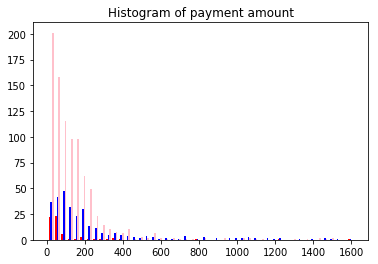

In [334]:
print("Average amount of payments that converts to at least 1 voucher:", 
      np.average(payments_with_voucher.amount))

print("Average amount of payments that converts to payouts:", 
      np.average(payments_with_payout.amount))

print("Average amount of payments that resulted in fallbacks:", 
      np.average(payments_with_fallback.amount))

print("Standard deviation of payments that converts to at least 1 voucher:",
      np.std(payments_with_voucher.amount))

print("Standard deviation of payments that converts to payouts:",
      np.std(payments_with_payout.amount))

print("Standard deviation of payments that resulted in fallbacks:",
      np.std(payments_with_fallback.amount))

# 2 sample independent t test with 2 tailed significance threshold
print("\nTest of payment amount between vouchers and payouts:\n",
      stats.ttest_ind(payments_with_voucher.amount,
                payments_with_payout.amount,
                equal_var=False))
print("\nTest of payment amount between payouts and fallbacks:\n",
      stats.ttest_ind(payments_with_payout.amount,
                payments_with_fallback.amount,
                equal_var=False))
print("\nTest of payment amount between vouchers and fallbacks:\n",
      stats.ttest_ind(payments_with_voucher.amount,
                payments_with_fallback.amount,
                equal_var=False))


# Plot histogram of different cases
plt.figure()
plt.hist( [payments_with_voucher.amount,
           payments_with_payout.amount,
           payments_with_fallback.amount],
         bins="auto", color=["red","blue","pink"], histtype="bar",
         label=["voucher","payout","fallback"] )
plt.title("Histogram of payment amount")
plt.show()

We see that average amount of payments that converts to at least 1 voucher are lower than that of other payouts. The difference is statistically significant even with the proportionate higher standard deviation amount the samples. 

Average transfer value with vouchers: 54.6223809524
Average transfer value with payouts: 220.306193182
Standard deviation of transfer value with vouchers: 69.9749610425
Standard deviation of transfer value with payouts: 413.226869273

Test of transfer amount between vouchers and payouts:
 Ttest_indResult(statistic=-11.783342017785957, pvalue=2.7240148939491613e-29)


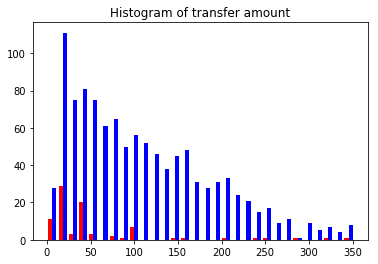

In [332]:
print("Average transfer value with vouchers:", np.average(vouchers.nominal_value))
print("Average transfer value with payouts:", np.average(payouts.nominal_value))
print("Standard deviation of transfer value with vouchers:", np.std(vouchers.nominal_value))
print("Standard deviation of transfer value with payouts:", np.std(payouts.nominal_value))

# 2 sample independent t test with 2 tailed significance threshold
print("\nTest of transfer amount between vouchers and payouts:\n",
      stats.ttest_ind(vouchers.nominal_value, payouts.nominal_value, equal_var=False))

plt.hist( [vouchers.nominal_value,
           payouts.nominal_value],
         bins="auto", histtype="bar",
         color=["red","blue"],label=["voucher","payout"])
plt.title("Histogram of transfer amount")
plt.show()


In [331]:
print("For payments with at least 1 voucher, the male ratio is",
      np.average(payments_with_voucher.isMale))
print("For payments with payouts, the male ratio is",
      np.average(payments_with_payout.isMale))
print("For payments with fallback auto-payout, the male ratio is",
      np.average(payments_with_fallback.isMale))
print("Male ratio standard deviation of at least 1 voucher:",
      np.std(payments_with_voucher.isMale))
print("Male ratio standard deviation of payout:",
      np.std(payments_with_payout.isMale))
print("Male ratio standard deviation of fallbacks:",
      np.std(payments_with_fallback.isMale))


# 2 sample independent t test with 2 tailed significance threshold
print("\nTest of male ratio between payments with vouchers and payments with payouts:\n",
      stats.ttest_ind(payments_with_voucher.isMale,
                      payments_with_payout.isMale,equal_var=False))

print("\nTest of male ratio between payments with vouchers and fallbacks:\n",
      stats.ttest_ind(payments_with_voucher.isMale,
                payments_with_fallback.isMale,
                equal_var=False))

print("\nTest of male ratio between payouts and fallbacks:\n",
      stats.ttest_ind(payments_with_payout.isMale,
                payments_with_fallback.isMale,
                equal_var=False))

For payments with at least 1 voucher, the male ratio is 0.742424242424
For payments with payouts, the male ratio is 0.632218844985
For payments with fallback auto-payout, the male ratio is 0.651162790698
Male ratio standard deviation of at least 1 voucher: 0.437299081505
Male ratio standard deviation of payout: 0.482201386384
Male ratio standard deviation of fallbacks: 0.476602361207

Test of male ratio between payments with vouchers and payments with payouts:
 Ttest_indResult(statistic=1.8239067747996014, pvalue=0.071184231188497163)

Test of male ratio between payments with vouchers and fallbacks:
 Ttest_indResult(statistic=1.6148456945012593, pvalue=0.11045799912173027)

Test of male ratio between payouts and fallbacks:
 Ttest_indResult(statistic=-0.61118217843794342, pvalue=0.54132009743789522)


#### Key findings:
** - Payment amount that converted to payouts are typically larger than that of vouchers or resulted in fallbacks.**

** - This can mean that if the refund amount is larger, the user is more concious about setting credit payout in the system.**

** - Around 2/3 of payment jobs resulted in fallbacks. They are around the same payment amount as jobs that converted to vouchers. **

** - Payments with at least 1 vouchers has are composed more of male users than that of payments with payouts. Although this difference is only slightly significant. **

** - Gender composition for payments with vouchers are around the same as for payments ended up fallback.**

** - Potential area on improving conversion rate can be focused on fallback payment orders that has similar amount and user characteristics as payments that converted to vouchers. E.g. A male customer with a small payment amount can be incentivized with a small upside amount for converting to vouchers.**

### Add additional payment features

We want to see which payment features predicts higher voucher percentage. Let's start by adding a few features that may exhibit trends for voucher transfer. 

* Booleon column to indicate whether the payment job have at least 1 voucher transfer executed
* Sum of the total upside amount for each payment job
* Sum of the total transferred amount. It should equal to the payment job amount for all closed payment jobs
* Timespan of the payment job from start to close
* Number of pages browsed before payment job is closed
* Number of unique pages browsed before payment job is closed

In [335]:
# Add with voucher indicator to payment table
# withVoucher = 1 indicates the payment job is converted to at least 1 voucher
payments["withVoucher"] = (payments.payment_job_id.isin(vouchers.payment_job_id))*1

# Add total upside amount to payment table
payment_upside = transfers.groupby(["payment_job_id"])[["upside_amount"]].sum().reset_index()
payments = pd.merge(payments, payment_upside, on=['payment_job_id'], how='left')

# Add total transfer amount to payment table
# Further check if total transfer amount is the same as payment job amount
transfer_value = transfers.groupby(["payment_job_id"])[["nominal_value"]].sum().reset_index()
transfer_value.columns = ["payment_job_id","transfer_amount"]
payments = pd.merge(payments, transfer_value, on=['payment_job_id'], how='left')

# Round the number columns to 2 decimal points - Not Needed
#payments["amount"].apply(lambda x: np.round(x, decimals=2))
#payments["upside_amount"].apply(lambda x: np.round(x, decimals=2))
#payments["transfer_amount"].apply(lambda x: np.round(x, decimals=2))

In [336]:
# Change to datetime type
payments["created_at"] =  pd.to_datetime(payments["created_at"], format="%Y-%m-%d %H:%M:%S.%f")
payments["closed_at"] =  pd.to_datetime(payments["closed_at"], format="%Y-%m-%d %H:%M:%S.%f")

# Add timespan column indicating the full lifespan of a payment job in mins
payments["timespan_mins"] = (payments.closed_at-payments.created_at).astype('timedelta64[m]')

In [337]:
# Add the number of pages browsed for each payment transfer
num_pages = log.groupby(["payment_job_id"])[["created_at"]].count().reset_index()
num_pages.columns = ["payment_job_id", "num_pages"]
payments = pd.merge(payments, num_pages, on=['payment_job_id'], how='left')

# Add the number of unique pages browsed for each payment transfer
num_unique_pages = log.groupby(["payment_job_id"]).agg({"url_view": pd.Series.nunique}).reset_index()
num_unique_pages.columns = ["payment_job_id", "num_unique_pages"]
payments = pd.merge(payments, num_unique_pages, on=['payment_job_id'], how='left')

In [338]:
# Add the total voucher amount each payment job
payment_voucher = transfers[transfers.payout_method_id.isnull()].groupby(["payment_job_id"])[["nominal_value"]].sum().reset_index()
payment_voucher.columns = ["payment_job_id", "voucher_amount"]
payments = pd.merge(payments, payment_voucher, on="payment_job_id", how="left")

In [339]:
# Replace NaN value with 0
payments["upside_amount"].fillna(0, inplace=True)
payments["transfer_amount"].fillna(0, inplace=True)
payments["timespan_mins"].fillna(0, inplace=True)
payments["num_pages"].fillna(0, inplace=True)
payments["num_unique_pages"].fillna(0, inplace=True)
payments["voucher_amount"].fillna(0, inplace=True)

In [340]:
payments.head(3)

,payment_job_id,payment_issuer_id,amount,gender,status,created_at,closed_at,isMale,withVoucher,upside_amount,transfer_amount,timespan_mins,num_pages,num_unique_pages,voucher_amount
0,3N2/gEX,ku67iuf,65.26,Male,Closed,2017-03-28 02:06:34.254341,2017-03-28 11:08:15.763343,1,0,0.0,65.26,541.0,5.0,2.0,0.0
1,t1hcFJ4,zxqi2ey,10.25,Male,Closed,2017-03-28 02:06:09.882150,2017-03-28 12:06:04.563339,1,0,0.0,10.25,599.0,7.0,3.0,0.0
2,bozVMtI,ku67iuf,96.18,Male,Closed,2017-03-28 02:06:25.162234,2017-03-28 12:00:34.403814,1,0,0.0,96.18,594.0,12.0,2.0,0.0


### What factors contribute to higher voucher amount?

In [353]:
from sklearn.utils import shuffle

# Filter only for payment jobs that have been paid
payments = payments[payments.status.isin(["Closed","Fallback"])]
# Shuffle the data
payments = shuffle(payments)

# Subset traning data, training labels, testing data and testing labels
# Will be used for further regression modeling and testing
train_data = payments[:-100][["amount","isMale","upside_amount",
                              "timespan_mins","num_pages",
                              "num_unique_pages"]]
train_labels = payments[:-100][["voucher_amount"]]

test_data = payments[-100:][["amount","isMale","upside_amount",
                              "timespan_mins","num_pages",
                              "num_unique_pages"]]
test_labels = payments[-100:][["voucher_amount"]]

In [354]:
print("training set size", train_data.shape)
print("training label size", train_labels.shape)
print("test set size", test_data.shape)
print("test label size", test_labels.shape)

training set size (1189, 6)
training label size (1189, 1)
test set size (100, 6)
test label size (100, 1)


In [356]:
# Create linear model
lm = sklearn.linear_model.LinearRegression()
lm.fit(train_data, train_labels)

# The coefficients
print('Coefficients: \n', lm.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((lm.predict(test_data) - test_labels) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(test_data, test_labels))

Coefficients: 
 [[ -1.08005767e-03  -2.86671949e-02   1.67708575e+01   4.06995848e-05
   -1.86880966e-01   1.75739752e+00]]
Mean squared error: 22.43
Variance score: 0.83


In [361]:
# To understand the p-value and effect of each feature,
# let's fit a model with statmodels package
X = sm.add_constant(train_data)
est = sm.OLS(train_labels, X)
print(est.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         voucher_amount   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     679.8
Date:                Tue, 20 Jun 2017   Prob (F-statistic):               0.00
Time:                        01:09:11   Log-Likelihood:                -4566.2
No. Observations:                1189   AIC:                             9146.
Df Residuals:                    1182   BIC:                             9182.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1374      0.633  

#### Key Findings:

**Note: The regression result shows which payment job characteristics correlated with higher voucher amount. However, given the data is observational, we shouldn't interpret this as causal effect. A typical mistake is to view it as if increasing strength of certain payment features will result in increased vouchers. This is wrong interpretation**

**- The features that has a statistically significant relationship with voucher amount are gender, upside amount, number of pages browsed before payment closed and number of unique pages landed before payment closed**

**- More pages viewed before payout corresponds to slightly lower voucher amount, on the contrary, more unique pages landed before payout corresponds to higher voucher amount. This can be understood that if a user landed on pages with similar information over and over, it will end up with a lower converted voucher amount. Whilst if guiding users through different pages with key information for transfer, it increases the converted voucher amount**

**- All payments with upside amount ended up with partial voucher payout. Although this most likely is due to the fact that only when users select vouchers does he/she receive upside. But the large coefficient suggest that given an additional 1 euro/dollar of upside incentive, the resulting voucher amount will increase by near 17 times.**